In [1]:
import pandas as pd
import re
import requests
import datetime
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn import metrics
import catboost
import lightgbm


plt.rcParams['figure.figsize'] = [40, 40]
%matplotlib inline

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 15)

**Load datasets and preprocessing information with adding new features.**
**Create train and validation set for models**

In [3]:
# Loading data for countries and removing unnecesary columns
countries = pd.read_csv("./datasets/countries.csv")
countries.drop(['iso_alpha2', 'iso_numeric', 'name', 'official_name'], axis='columns', inplace=True)

In [4]:
"""Loading data for confirmed cases. Grouping data by country, ignoring province.
Delete latitude and longtitude columns.
Each date must be on a single row.
"""


data_confirmed = pd.read_csv("./datasets/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
data_confirmed = data_confirmed.groupby('Country/Region').sum()
data_confirmed.drop(['Lat', 'Long'], axis='columns', inplace=True)
data_confirmed = data_confirmed.iloc[:, 4:].stack().reset_index()
data_confirmed.columns = ['ccse_name', 'date', 'confirmed']
data_confirmed

,ccse_name,date,confirmed
0,Afghanistan,1/26/20,0
1,Afghanistan,1/27/20,0
2,Afghanistan,1/28/20,0
3,Afghanistan,1/29/20,0
4,Afghanistan,1/30/20,0
...,...,...,...
14240,Zimbabwe,4/7/20,11
14241,Zimbabwe,4/8/20,11
14242,Zimbabwe,4/9/20,11
14243,Zimbabwe,4/10/20,13


In [5]:
"""Loading data for deaths. Grouping data by country, ignoring province.
Delete latitude and longtitude columns.
Each date must be on a single row.
"""


data_deaths = pd.read_csv("./datasets/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
data_deaths = data_deaths.groupby('Country/Region').sum()
data_deaths.drop(['Lat', 'Long'], axis='columns', inplace=True)
data_deaths = data_deaths.iloc[:, 4:].stack().reset_index()
data_deaths.columns = ['ccse_name', 'date', 'deaths']
data_deaths

,ccse_name,date,deaths
0,Afghanistan,1/26/20,0
1,Afghanistan,1/27/20,0
2,Afghanistan,1/28/20,0
3,Afghanistan,1/29/20,0
4,Afghanistan,1/30/20,0
...,...,...,...
14240,Zimbabwe,4/7/20,2
14241,Zimbabwe,4/8/20,3
14242,Zimbabwe,4/9/20,3
14243,Zimbabwe,4/10/20,3


In [6]:
""" Loading data for quarantines and grouping them by country,
ignoring region level
"""


quarantines = pd.read_csv("./datasets/quarantine_dates.csv")
quarantines_proccessed = quarantines.groupby('Country').max().reset_index()
quarantines_proccessed.drop(['Place', 'Level'], axis='columns', inplace=True)

In [7]:
"""Merging all info for confirmed cases and deaths with country's info
Casting date to datetime datatype
Delete rows with confirmed == 0
"""


data_all = countries.merge(data_confirmed, how='left', 
                           left_on='ccse_name', right_on='ccse_name')
data_all = data_all.merge(data_deaths, how='left',
                          left_on=('ccse_name', 'date'), right_on=('ccse_name', 'date'))
data_all['date'] = pd.to_datetime(data_all.date)
data_all = data_all[data_all.confirmed != 0]
data_all

,iso_alpha3,ccse_name,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,date,confirmed,deaths
29,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-24,1,0
30,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-25,1,0
31,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-26,1,0
32,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-27,1,0
33,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-28,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13008,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-07,39,1
13009,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-08,39,1
13010,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-09,39,1
13011,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-10,40,2


In [8]:
""" Add new feature - days from first confirmed case
First create dataframe with first day of confirmed case
"""


data_all_2 = data_all[(data_all.date < pd.to_datetime("2020-05-01")) & 
                      (data_all.date > pd.to_datetime("2020-01-01")) | (data_all.confirmed != -1)]
data_days = data_all_2[["ccse_name", "date"]].groupby("ccse_name").min()
data_days.columns = ["date_first_confirmed"]

In [9]:
"""Merge dataframes and count days from first confirmed
"""


data_all_2 = data_all_2.merge(data_days, how='left',
                              left_on='ccse_name', right_on='ccse_name')
data_all_2["date_first_confirmed"] = (data_all_2.date - data_all_2.date_first_confirmed).dt.days
data_all_2

,iso_alpha3,ccse_name,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,date,confirmed,deaths,date_first_confirmed
0,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-24,1,0,0
1,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-25,1,0,1
2,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-26,1,0,2
3,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-27,1,0,3
4,AFG,Afghanistan,60,4.6,652860,18.0,-62920.0,38928346,0.25,0.0050,2020-02-28,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6925,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-07,39,1,20
6926,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-08,39,1,21
6927,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-09,39,1,22
6928,ZMB,Zambia,25,4.7,743390,18.0,-8000.0,18383955,0.45,0.0024,2020-04-10,40,2,23


In [10]:
"""Extracting number of confirmed cases and deaths
from previous day
"""


prev_day_confirmed = data_all_2['confirmed'].iloc[:-1]
prev_day_deaths = data_all_2['deaths'].iloc[:-1]
temp_data = data_all_2[['ccse_name', 'date']].iloc[1:]
temp_data["prev_day_confirmed"] = prev_day_confirmed.values
temp_data["prev_day_deaths"] = prev_day_deaths.values

temp_data

,ccse_name,date,prev_day_confirmed,prev_day_deaths
1,Afghanistan,2020-02-25,1,0
2,Afghanistan,2020-02-26,1,0
3,Afghanistan,2020-02-27,1,0
4,Afghanistan,2020-02-28,1,0
5,Afghanistan,2020-02-29,1,0
...,...,...,...,...
6925,Zambia,2020-04-07,39,1
6926,Zambia,2020-04-08,39,1
6927,Zambia,2020-04-09,39,1
6928,Zambia,2020-04-10,39,1


In [11]:
"""Add new feature - previous day confirmed cases and deaths
Filling NaN values
"""


data_all_2 = data_all_2.merge(temp_data, how='left', 
                              left_on=('ccse_name', 'date'), right_on=('ccse_name', 'date'))
data_all_2.fillna(value=0, axis=0, inplace=True)

In [12]:
"""Create train set and labels for a model
Select features for model
Create validation set for a model
Three countries will be dropped from train set for validation
"""
features = ['density', 'median_age', 'urban_pop_rate',
            'date_first_confirmed', 'prev_day_confirmed', 'prev_day_deaths']
labels = ['iso_alpha3', 'date', 'confirmed', 'deaths']

DAYS_VALID = 7
day_start = data_all_2.date.max() - pd.to_timedelta(DAYS_VALID, unit='d')  

train_X = data_all_2[data_all_2.date < day_start]
train_y = train_X[labels]
train_X = train_X[features]

valid_data = data_all_2[data_all_2.date >= day_start]


**Create and train models for prediction of confirmed cases and deaths**

In [13]:
"""Used models:
XGBRegressor - xgb
CatBoostRegressor - cbr
LGBMRegressor - lgbmr
"""
xgb_confirmed = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)
xgb_deaths = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)
cbr = catboost.CatBoostRegressor(iterations=1000, learning_rate=0.01)
lgbmr = lightgbm.LGBMRegressor(learning_rate=0.01, n_estimators=1000)


In [14]:
"""This function will be used for plotting prediction 
   compare to real counts of cases
"""


def plot_predictions_valid(model_name, valid_data, features, 
                     day_start, days, target, country):
    first_day_of_prediction = pd.to_datetime(day_start)
    last_day_of_prediction = pd.to_datetime(day_start) + pd.to_timedelta(days, unit='d')
    days = pd.date_range(first_day_of_prediction, last_day_of_prediction)
    valid_data = valid_data[valid_data.iso_alpha3 == country]
    valid_X = valid_data[features]
    predictions = model_name.predict(valid_X) 
    valid_y = valid_data[target]
    print(metrics.mean_squared_error(valid_y, predictions))
    plt.figure(figsize=(10, 5))
    plt.title(country)
    plt.plot(days, predictions, label='Predicted_'+target)
    plt.plot(days, valid_y.values, label=target)
    plt.legend()
    return predictions
    

**XGBoost Regressor**


In [15]:
"""Train XGBRegressor. For confirmed cases and deaths
separate models created
"""
train_y_xgb_confirmed = train_y[[labels[2]]]
train_y_xgb_deaths = train_y[[labels[3]]]
xgb_confirmed.fit(train_X, train_y_xgb_confirmed)
xgb_deaths.fit(train_X, train_y_xgb_deaths)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

421688.13449057937


array([ 4704.,  5413.,  6126.,  7174.,  8549.,  9634., 11423., 15232.],
      dtype=float32)

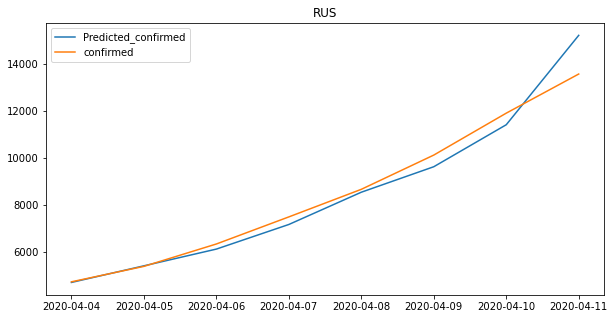

In [17]:
predictions_confirmed = plot_predictions_valid(xgb_confirmed, valid_data, features, day_start, 
                                         DAYS_VALID, 'confirmed', 'RUS')
predictions_confirmed.round()

**Training best model on the whole dataset**

In [18]:
model_confirmed = xgb_confirmed
model_deaths = xgb_deaths
train_X_all = data_all_2[features]
train_y_all_confirmed = data_all_2[[labels[2]]]
train_y_all_deaths = data_all_2[[labels[3]]]

model_confirmed.fit(train_X_all, train_y_all_confirmed)
model_deaths.fit(train_X_all, train_y_all_deaths)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

**Predict confirmed cases and deaths to the end of the year**

In [19]:
data_all_2.drop('ccse_name', axis='columns', inplace=True)
data_all_2.rename(columns={'iso_alpha3': 'country'}, inplace=True)

In [20]:
"""Function for prediction next day's confirmed cases and deaths.
   Arguments:
   model_confirmed - model, trained to predict number of confirmed cases next day
   model_deaths - model, trained to predict number of deaths next day
   data - pandas.DataFrame with all information
   features - list, features which model used
"""


def predict_next_day(model_confirmed, model_deaths, data, features):
    last_date = data['date'].max() 
    next_date = last_date + pd.to_timedelta(1, unit='d')
    prev_data = data[data.date == last_date]
    next_data = prev_data.copy()
    next_data['date_first_confirmed'] += 1
    next_data['date'] = next_date
    next_data['prev_day_confirmed'] = prev_data['confirmed']
    next_data['prev_day_deaths'] = prev_data['deaths']
    next_X = prev_data[features]
    next_data['confirmed'] = model_confirmed.predict(next_X)
    next_data['deaths'] = model_deaths.predict(next_X)
    
    return next_data

In [21]:
"""Function for prediction number of new cases and deaths 
   Arguments:
   data - pandas.DataFrame with all information
   days - array of pandas.datetime objects
   model_1 - model for confirmed cases
   model_2 - model for deaths
   features - list, features which models used
"""


def predict(data, days, model_1, model_2, features):
    pred_data = data.copy()
    for day in days:
        next_data = predict_next_day(model_1, model_2, pred_data, features)
        pred_data = pd.concat([pred_data, next_data])
    return pred_data

In [22]:
"""Define borders of time, for which prediction will be obtain
   Make prediction and select new data.
   Round number of cases and deaths by cast those values to int64 datatype
"""


dates = pd.date_range("2020-04-12", "2020-12-31")
data_new = predict(data_all_2, dates, model_confirmed, model_deaths, features)
prediction_data = data_new[data_new.date >= dates[0]]
prediction_data = prediction_data.rename({'confirmed': 'prediction_confirmed',
                        'deaths': 'prediction_deaths'}, axis='columns')
prediction_data = prediction_data.astype({'prediction_confirmed': 'int64', 'prediction_deaths': 'int64'})

In [27]:
"""Function for constructing plots for predicted data
"""


def plot_predictions(data, country, target):
    plot_data = data[data.country == country]
    x = plot_data['date']
    y = plot_data[target]
    plt.figure(figsize=(20, 5))
    plt.title(country)
    plt.plot(x, y, label='predicted_'+target)
    plt.legend()

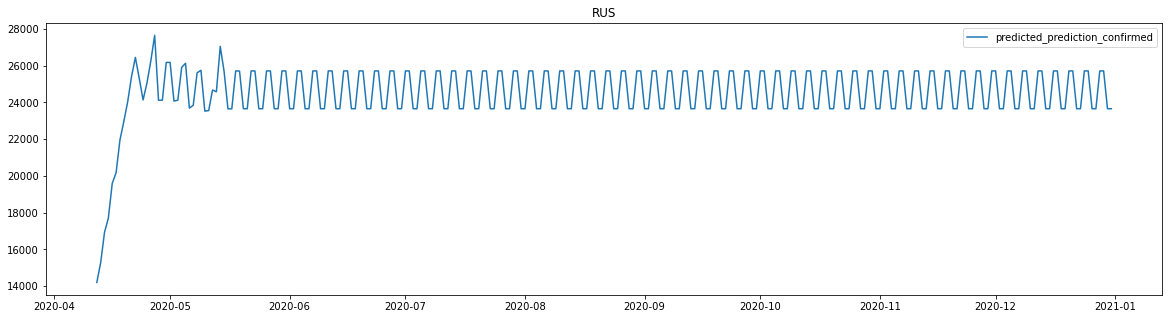

In [28]:
plot_predictions(prediction_data, 'RUS', 'prediction_confirmed')

In [25]:
"""Get sample submission"""


submission = pd.read_csv("./datasets/sample_submission_dDoEbyO.csv")
submission

,date,country,prediction_confirmed,prediction_deaths
0,2020-04-05,AFG,396,7
1,2020-04-06,AFG,449,8
2,2020-04-07,AFG,510,10
3,2020-04-08,AFG,579,11
4,2020-04-09,AFG,658,12
...,...,...,...,...
45794,2020-12-27,ZWE,14862924,148629
45795,2020-12-28,ZWE,14862924,148629
45796,2020-12-29,ZWE,14862924,148629
45797,2020-12-30,ZWE,14862924,148629


In [26]:
"""Select rows for submission dataframe and write it to csv file"""


results = prediction_data[['date', 'country', 'prediction_confirmed', 'prediction_deaths']].sort_values(by=['country', 'date'])
results.to_csv('./submission.csv', index=False)

In [ ]:
data_recovered = pd.read_csv("./datasets/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")